In [1]:
import xgboost as xgb
import graphviz
import os
from numpy import loadtxt
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

FEATURES = ['freq', 'attack_angle', 'chord_length',
            'free_stream_velocity', 'suction_side_thickness']
def loss(y_n):
    return 0.5*((y-y_n)**2)

def ensemble(y1, y2, shrinkage):
    return (y1 + y2*shrinkage)# /(1+shrinkage)

def load_data():
    dataset = pd.read_csv('foil.csv', sep=",")
    dataset = dataset[dataset.decibels > 0].reset_index()
    df_train = dataset[0:1200]
    df_test = dataset[1200:1503]
    y_train = df_train['decibels'].values
    y_test = df_test['decibels'].values
    omit_cols = ['index', 'decibels']    
    X_train = df_train.drop(omit_cols, axis=1).values
    X_test = df_test.drop(omit_cols, axis=1).values
    return y_train, y_test, X_train, X_test

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def do_xgb(depth):
    y_train, y_test, X_train, X_test = load_data()
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_test = xgb.DMatrix(X_test, label=y_test)
    xgb_train.colnames = FEATURES
    xgb_test.colnames = FEATURES
    params = {'max_depth': depth, 'eta': 1, 'silent': 1,
              'objective': 'reg:linear', 'verbose_eval': False
             }
    model = xgb.train(params, xgb_train, 100)
    plot_tree(model, num_trees=1)
    plt.rcParams["figure.figsize"] = (40, 40)
    plt.show()
    
def do_lgb(leaf):
    y_train, y_test, X_train, X_test = load_data()    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    params = {
        'num_leaf': leaf,
        'metric': ('l1', 'l2'),
        'verbose': 0
    }
    evals_result = {}
    print('Start training...')
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=[lgb_train, lgb_test],
                    feature_name=FEATURES,
                    categorical_feature=[21],
                    evals_result=evals_result,
                    verbose_eval=50)
    print('Plot 1st tree...')
    ax = lgb.plot_tree(gbm, tree_index=83, 
                       show_info=['split_gain', 'internal_value',
                                  'internal_count', 'leaf_count']
                      )
    plt.rcParams["figure.figsize"] = (40, 40)
    plt.show()
    
def regu():
    from sklearn import ensemble
    from sklearn import datasets

    X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)
    X = X.astype(np.float32)

    # map labels from {-1, 1} to {0, 1}
    labels, y = np.unique(y, return_inverse=True)

    X_train, X_test = X[:2000], X[2000:]
    y_train, y_test = y[:2000], y[2000:]

    original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                       'min_samples_split': 5}

    plt.figure()

    for label, color, setting in [('No shrinkage', 'orange',
                                   {'learning_rate': 1.0, 'subsample': 1.0}),
                                  ('learning_rate=0.1', 'turquoise',
                                   {'learning_rate': 0.1, 'subsample': 1.0}),
                                  ('subsample=0.5', 'blue',
                                   {'learning_rate': 1.0, 'subsample': 0.5}),
                                  ('learning_rate=0.1, subsample=0.5', 'gray',
                                   {'learning_rate': 0.1, 'subsample': 0.5}),
                                  ('learning_rate=0.1, max_features=2', 'magenta',
                                   {'learning_rate': 0.1, 'max_features': 2})]:
        params = dict(original_params)
        params.update(setting)

        clf = ensemble.GradientBoostingClassifier(**params)
        clf.fit(X_train, y_train)

        # compute test set deviance
        test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

        for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
            # clf.loss_ assumes that y_test[i] in {0, 1}
            test_deviance[i] = clf.loss_(y_test, y_pred)

        plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
                '-', color=color, label=label)

    plt.legend(loc='upper left')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Test Set Deviance')

    plt.show()

# Bagging and Boosting

## Commonalities
- Bagging and boosting are both ensembling techniques.
    - Combination of weak learners to build a strong learner
- Can be applied to classifiers or regressors
    - Combine models result via averaging or voting to produce a single final result
- Not limited to decision trees

## Disambiguation

||Bootstrap Aggregation\* (Bagging)|Boosting|
|-|:-:|:-:|:-:|
|**Sampling**|Bootstrap (random sample with replacement)|All data could be used|
|**Modelling**|Used with low-bias/high-variance models like fully-grown decision trees (e.g. random forest). Models are trained _in parallel_ with datasets/attributes that differ as they are created by sampling with replacement|Sequential building of weak learners (high-bias/low variance, e.g. shallow trees). Subsequent weak learners are trained by adjustings weights based on residuals of previous weak learners (adaboost) or trained on the residuals directly (gbm) |
|**Error reduction focus**|Variance reduction with small negative impact on bias|Bias reduction with small negative impact on variance|

## Bagging
- Bagging = Bootstrap + Aggregation
- Bagging not limited to sample. Can also be used on attributes/features, i.e. random subspace method

### Simple (but not so good) example

Let original sample with size _n_ be: $$D=(x_1,x_2,...,x_n)$$

Decide on bootstrap number _k_. Sample _k_ number of samples with replacement from _D_.

Average the results of each function/model _f_:
$$f(D) = \frac{1}{k}\sum_{i=1}^{k} f(D_i)$$

In [3]:
import numpy as np
m = np.random.randint(1,100,500)
print('population σ: ' + str(np.std(m)))

population σ: 28.5870697344


In [4]:
s = np.random.choice(m, size=100, replace=False)
print('sample S: ' + str(np.std(s)))

sample S: 27.6376030075


In [5]:
B = []
for _ in range(50000):
    b = np.random.choice(s, size=100, replace=True)
    B.append(b)
print('S from bagging: ' + str(np.std(B)))

S from bagging: 27.6319284057


### Bagging in Random Forest

Step 1: From dataset with _N_ cases, samples _N_ cases with replacement (like bootstrapping above)

Step 2: Given _M_ number of attributes. _m_ (_m<<M_) number of attributes are selected at each node at random for splitting.

Step 3: Fully grow a tree without pruning.

Step 4: Repeat with until desired number of trees (forest) is achieved.

Step 5: Ensemble results

## Boosting

A method of improving initially weak model / base prediction (e.g. median) with each iteration.


### Adaptive boosting
$$F(x)=\sum_{t}{\alpha_t h_t(x)} $$

Fitting subsequent model by adding weights to sample based on residuals of previous model.

### Gradient boosting

Similar in concept to adaboost but uses gradient descent on residuals instead of weighting samples.

At each step, the new estimator will fit to residuals of the previous model:

Step 1: Define a base model / prediction $$F_m(x)$$

Step 2: Addition of an estimator _h(x)_ in:

$$F_{m+1}(x) = F_m(x) + h(x) = y$$

  where:
$$h(x) = y - F_m(x)$$

  given a squared error loss function:
$$ \frac{1}{2}(y-F(x))^2 $$

  Note that _y - F(x)_ is the negative gradient of this loss function.
  
### Preventing over-fitting in gradient boosting

#### Regularization
- Time/step-based regularization:
    - Reduce max boosting iterations
- Shrinkage (i.e. learning rate)

#### Attribute bagging (subsample)
- Bootstrap aggregation of attributes used in prediction

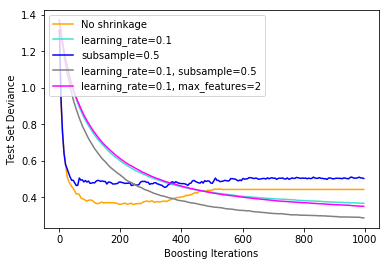

In [6]:
regu()

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
    
# Create the dataset
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])



### Attempt at building boosting model

base model loss: 12.7144012677
2nd model loss: 12.0140994274
3rd model loss: 11.4461259093


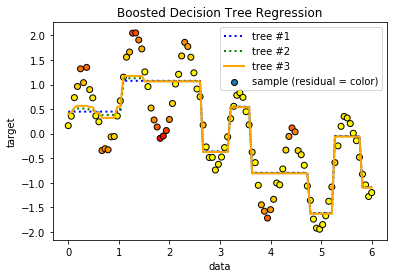

In [8]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=3)
regr_1.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
col = loss(y_1)
print("base model loss: " + str(sum(col)))

regr_1.fit(X, y - y_1)
h_1 = regr_1.predict(X)

y_2 = ensemble(y_1, h_1, 0.1)
col2 = loss(y_2)
print("2nd model loss: " + str(sum(col2)))

regr_1.fit(X, y - y_2)
h_2 = regr_1.predict(X)

y_3 = ensemble(y_2, h_2, 0.1)
col3 = loss(y_3)
print("3rd model loss: " + str(sum(col3)))


# Plot the results
plt.figure()
plt.scatter(X, y, c=col, label="sample (residual = color)", edgecolor="black",
            cmap=plt.get_cmap('autumn_r'))
plt.plot(X, y_1, linestyle=':', c="blue", label="tree #1", linewidth=2)
# plt.plot(X, y_2, linestyle=':', c="green", label="residuals", linewidth=2)
plt.plot(X, y_2, linestyle=':', c="green", label="tree #2", linewidth=2)
plt.plot(X, y_3, c="orange", label="tree #3", linewidth=2)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

### Now fast forward 100 boosting iterations:

loss: 0.849663593626


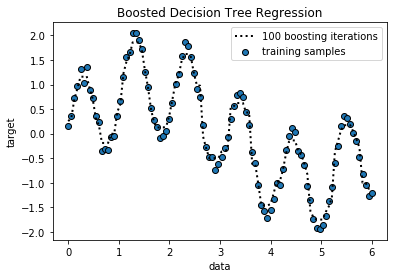

In [9]:
col = col3
y_n = y_3
regr = DecisionTreeRegressor(max_depth=2)

for i in range(0, 100):
    regr.fit(X, y - y_n, sample_weight=col)
    y_o = regr.predict(X)
    y_n = ensemble(y_n, y_o, 0.1)
    col = loss(y_n)
    
print("loss: " + str(sum(col)))
# Plot the results
plt.figure()
plt.scatter(X, y, label="training samples", edgecolor="black")
plt.plot(X, y_n, c="black", linestyle=':', label="100 boosting iterations", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

# XGBoost vs LightGBM

## Original tree growth method:

|library|growth method|description|main complexity param|
|-|-|-|-|
|XGBoost|level-wise tree growth |next level nodes|`max_depth`|
|LightGBM|leaf-wise tree growth|node with highest max delta loss|`num_leaf`|
    
However, recently XGBoost has introduced `grow_policy` param, choosing `lossguide` will result in similar method as LightGBM.

### Tree depth for XGB (depthwise)

In [10]:
interact(do_xgb, depth=(2,4))

A Jupyter Widget

<function __main__.do_xgb>

### Max number of leafs in LightGBM (lossguide)

In [11]:
interact(do_lgb, leaf=(3,9,2))

A Jupyter Widget

<function __main__.do_lgb>